In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 随机选择分子的次数
num=499
# 导入未加电荷的force文件
forcedata=[]
for i in range(num):
    forcefile="force_"+str(i+1)+".xvg"
    with open(forcefile) as f:
        lines=f.readlines()
        tmp=np.array([[float(i) for i in l.split()] for l in lines[26:]])[:,1:]
    forcedata.append(tmp)
forcedata=np.array(forcedata)
# 导入加了电荷的force文件
forceqdata=[]
for i in range(num):
    forceqfile="forceq_"+str(i+1)+".xvg"
    with open(forceqfile) as f:
        lines=f.readlines()
        tmp=np.array([[float(i) for i in l.split()] for l in lines[26:]])[:,1:]
    forceqdata.append(tmp)
forceqdata=np.array(forceqdata)
# 导入选中水分子坐标
posndata=[]
for i in range(num):
    posnfile="posn_"+str(i+1)+".xvg"
    with open(posnfile) as f:
        lines=f.readlines()
        tmp=np.array([[float(i) for i in l.split()] for l in lines[32:]])[:,1:]
    posndata.append(tmp)
posndata=np.array(posndata)
posndata=posndata.reshape((posndata.shape[0],posndata.shape[1],3,3))
forces=forceqdata-forcedata
forces=forces.reshape(forces.shape[0]*forces.shape[1],3)


In [4]:
# Separation vectors and distances
# 计算O原子、H原子和电荷中心的位置、单位向量和相对于Na离子的距离
# Na离子在盒子中心
lBox=2.5
boxCtr=[lBox/2,lBox/2,lBox/2]

# 距离盒子中心的Vec
# 通过mod with offset 将体系周期性保留
# ctrVec=(opositions-boxCtr)-3*np.floor(((opositions-boxCtr)+lBox/2)/lBox)
def ctrVec(m):
    return (m-boxCtr)-lBox*np.floor(((m-boxCtr)+lBox/2)/lBox)

# 距离盒子中心的最近距离
def ctrDist(m):
    return np.linalg.norm(ctrVec(m),axis=1).reshape(np.linalg.norm(ctrVec(m),axis=1).shape[0],1)


# 距离盒子中心的单位矢量
def ctrUnit(m):
    return ctrVec(m)/ctrDist(m)


In [6]:
opositions=posndata[:,:,0,:]
hpositions=posndata[:,:,1:3,:]
cpositions=0.5*posndata[:,:,0,:]+0.25*posndata[:,:,1,:]+0.25*posndata[:,:,2,:]
cpositions=cpositions.reshape(cpositions.shape[0]*cpositions.shape[1],3)
opositions=opositions.reshape(opositions.shape[0]*opositions.shape[1],3)
hpositions=hpositions.reshape(hpositions.shape[0]*hpositions.shape[1]*hpositions.shape[2],3)
unitVecsO=ctrUnit(opositions)
unitVecsC=ctrUnit(cpositions)
rValueC=ctrDist(cpositions)
rValueH=ctrDist(hpositions)
rValueO=ctrDist(opositions)

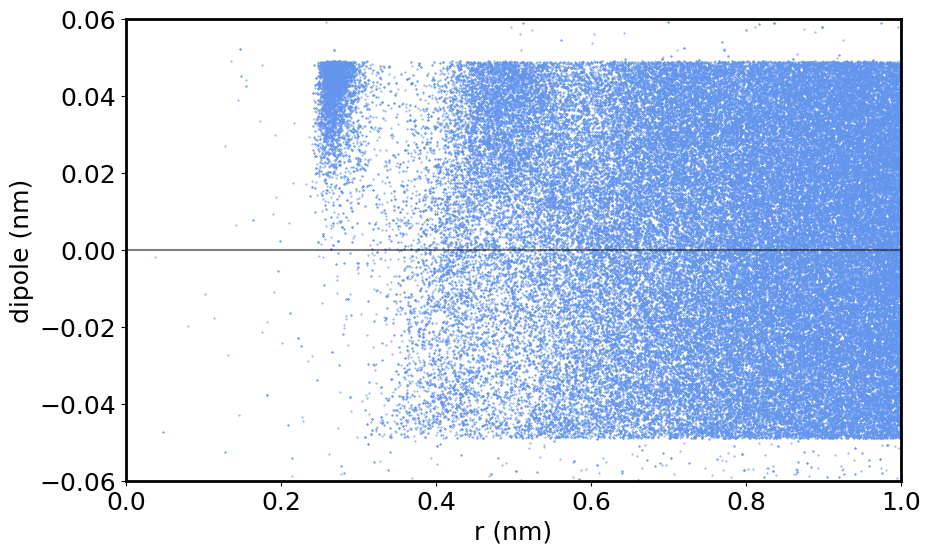

In [8]:
# compute and plot dipoles
# 水中的H电荷
qH=0.4238
# 水中的O电荷
qO=-2*qH
# 水的偶极矩
# 1debye=0.2 electron-Angstroms
#       =0.02 e nm
watdipole=1.8546*0.2
# 从O, H1, H2位置向量计算偶极子
dipoles=qO*(posndata[:,:,0,:])+qH*(posndata[:,:,1,:]+posndata[:,:,2,:])
dipoles=dipoles.reshape(dipoles.shape[0]*dipoles.shape[1],3)
# 沿单位矢量到盒中心的偶极子分量表，与COC到盒中心的距离
dipoledata=np.array([[np.dot(unitVecsC[i],dipoles[i])] for i in range(unitVecsC.shape[0])])
dipoledata=np.insert(rValueC,1,dipoledata.flatten(),axis=1)
# Scatter plot shows strongly oriented dipoles in near-neighbor shell, about 3A from Na+ ion center.
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.scatter(dipoledata[:,0],dipoledata[:,1],s=0.15,c="cornflowerblue")
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("dipole (nm)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.0,1.0)
plt.ylim(-0.06,0.06)
plt.savefig("dipole.png",dpi=300)

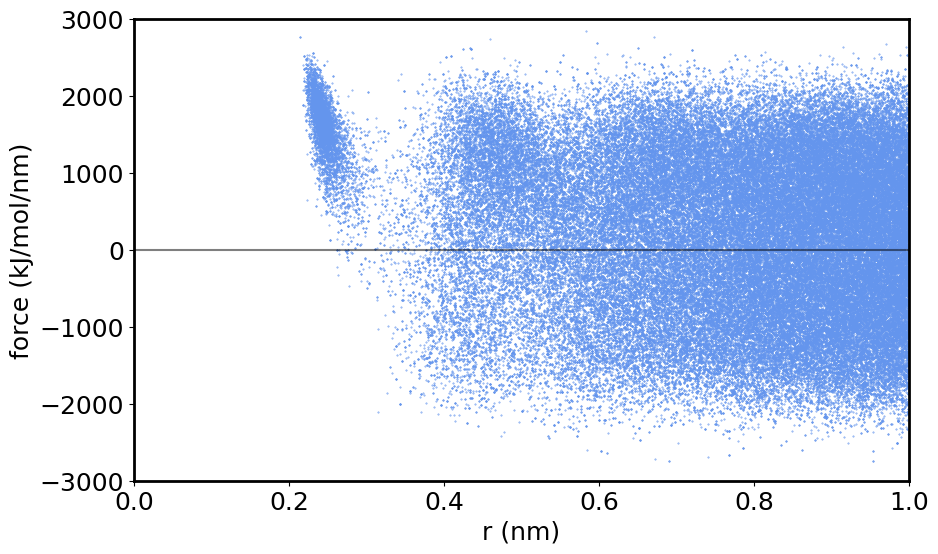

In [9]:
# compute and plot force
# Table of force components along unit vector to box center, versus O distance to box center 
# (test charge was added to O, force is Coulomb)
forcedata=np.array([[np.dot(unitVecsO[i],forces[i])] for i in range(unitVecsO.shape[0])])
forcedata=np.insert(rValueO,1,forcedata.flatten(),axis=1)
# Scatter plot shows strongly oriented Coulomb forces in near-neighbor shell, about 3A from Na+ ion center.
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.scatter(forcedata[:,0],forcedata[:,1],s=0.15,c="cornflowerblue")
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("force (kJ/mol/nm)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.0,1.0)
plt.ylim(-3000,3000)
plt.savefig("force.png",dpi=300)

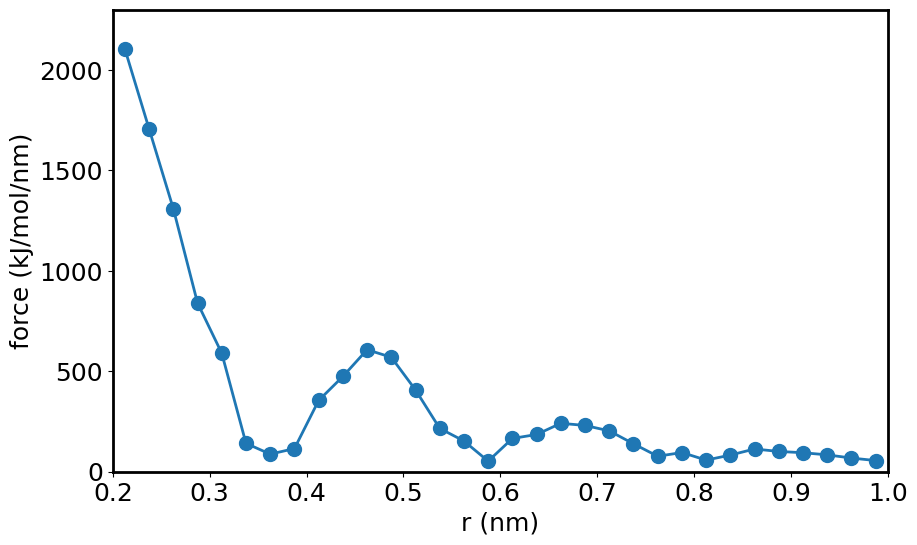

In [10]:
# Average force vs distance
# Perform average of quantity versus distance, by binning values between xMin and xMax in nx equal-width bins.
def avgVal(data,xmin,xmax,nx):
    dx=(xmax-xmin)/nx
    return np.around([[xmin+(k-1/2)*dx,data[np.logical_and(data[:,0] > (xmin+(k-1)*dx), data[:,0] <= (xmin+k*dx))][:,1].mean()] for k in range(1,nx+1)],4)

avgforce=avgVal(forcedata,0.2,1,32)
# Average force on unit test charge is repulsive and decays with distance;
# oscillations result from interaction with induced dipoles in near-neighbor shell.
# Force units are kJ/mol/nm; so 25kJ/mol/nm is kT/A
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(avgforce[:,0],avgforce[:,1],marker="o",linewidth=2,markersize=10)
plt.ylabel("force (kJ/mol/nm)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.2,1.0)
plt.ylim(0,2300)

plt.savefig("averageforce.png",dpi=300)

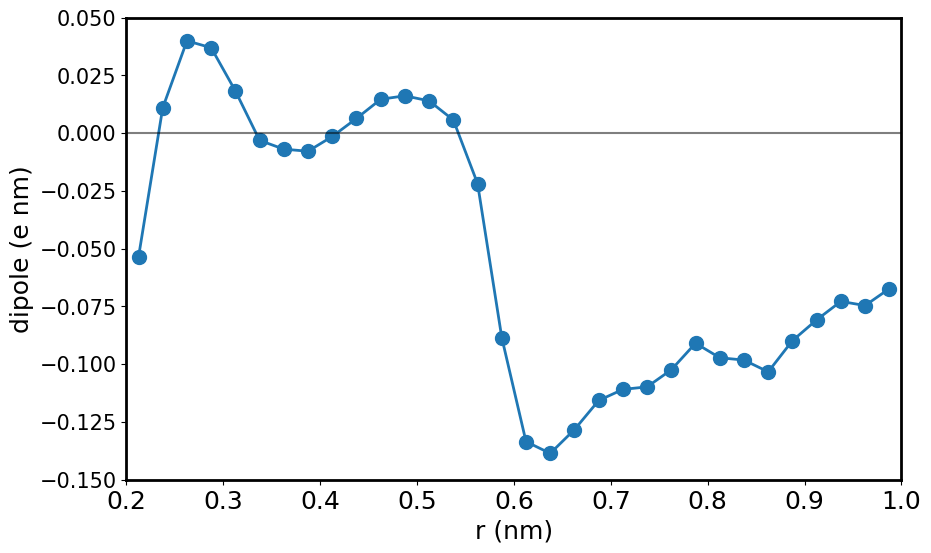

In [14]:
# average diploevs distance
# Average dipole component along vector from box center, versus distance to center.
avgDipole=avgVal(dipoledata,0.2,1,32)
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=15)
plt.plot(avgDipole[:,0],avgDipole[:,1],marker="o",linewidth=2,markersize=10)
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("dipole (e nm)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.2,1.0)
plt.ylim(-0.15,0.05)
plt.savefig("avgdipole.png",dpi=300)


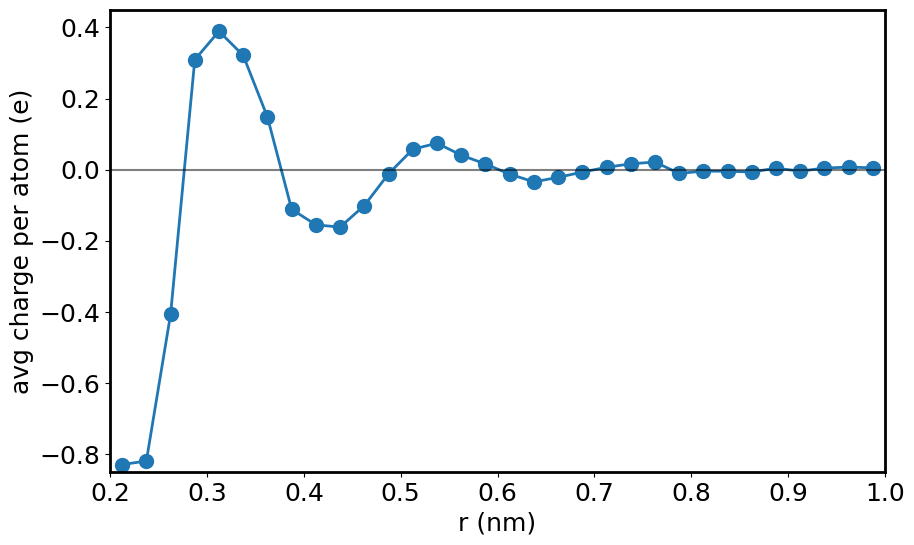

In [16]:
# average charge vs. distance
# Here we create and plot the charge distribution, from the set of atomic positions.
# List of charges of all atoms, corresponding to nObs randomly selected molecules observed 1001 times each
charges=np.array([qO,qH,qH]*1001*num)
atomrValues=np.linalg.norm(ctrDist(posndata.reshape(posndata.shape[0]*posndata.shape[1]*posndata.shape[2],3)),axis=1)
atomrValues=atomrValues.reshape(atomrValues.shape[0],1)
chargeData=np.insert(atomrValues,1,charges.flatten(),axis=1)
avgCharge=avgVal(chargeData,0.2,1,32)
# Average charge per atom present is strongly negative near Na+ ion, 
# reflecting the "heads" of oriented water dipoles in the near-neighbor shell; 
# slightly further away, the charge per atom is positive, corresponding to the "tails" of oriented near-neighbor dipoles.
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(avgCharge[:,0],avgCharge[:,1],marker="o",linewidth=2,markersize=10)
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("avg charge per atom (e)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.2,1.0)
plt.ylim(-0.85,0.45)
plt.savefig("avgcharge.png",dpi=300)

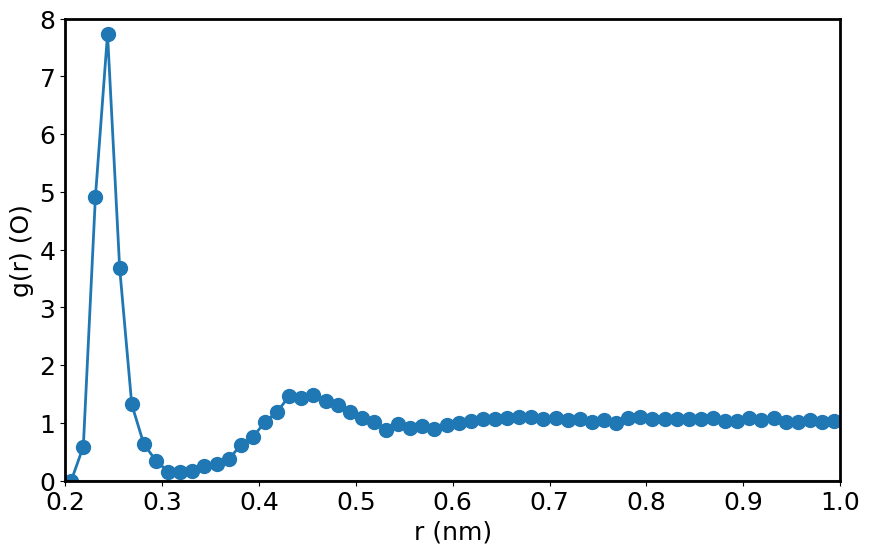

In [17]:
# Na-O, Na-H correlation functions
# Compute correlation function with respect to Na+ ion at box center.
# Select[ ] selects distance values in a given bin, and Length[ ] counts them.
# Far away from the center, we expect the number of counts in a bin equals its volume, 
# times the average density of observed particles, times the number of data points per particle (1001).
# We divide by this quantity to normalize g(r) to unity at large distances.
rho=num/pow(2.5,3)
def gOfr(data,xmin,xmax,nx):
    dx=(xmax-xmin)/nx
    return np.array([[xmin+(k-1/2)*dx,len(data[np.logical_and(data>(xmin+(k-1)*dx),data<=(xmin+k*dx))])/(4*np.pi*pow((xmin+(k-1/2)*dx),2)*dx*rho*1001)] for k in range(1,nx+1)])

 # Correlation function between Na+ ion at box center and oxygen atoms
gOfrDataO=gOfr(rValueO,0.2,1,64)
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(gOfrDataO[:,0],gOfrDataO[:,1],marker="o",linewidth=2,markersize=10)
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("g(r) (O)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.2,1.0)
plt.ylim(0,8)
plt.savefig("gr(O).png",dpi=300)   

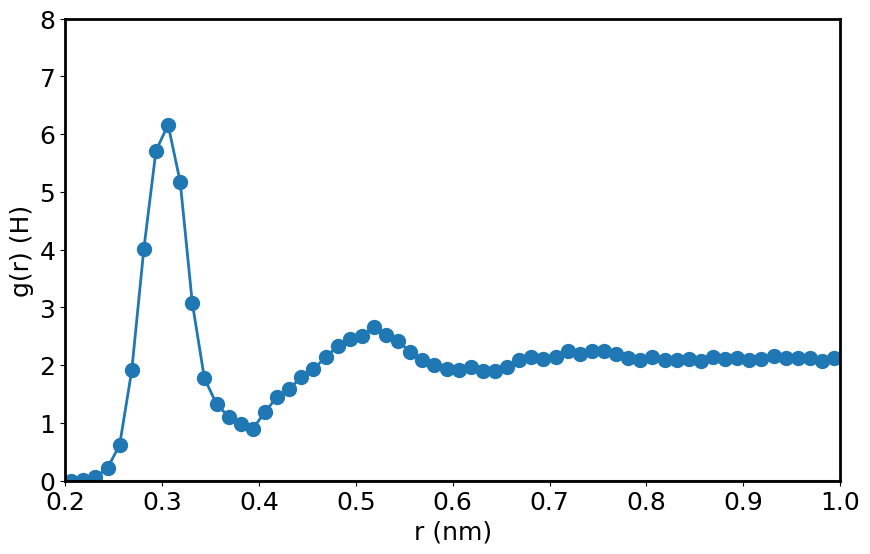

In [18]:
gOfrDataH=gOfr(rValueH,0.2,1,64)
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(gOfrDataH[:,0],gOfrDataH[:,1],marker="o",linewidth=2,markersize=10)
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("g(r) (H)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.2,1.0)
plt.ylim(0,8)
plt.savefig("gr(H).png",dpi=300)

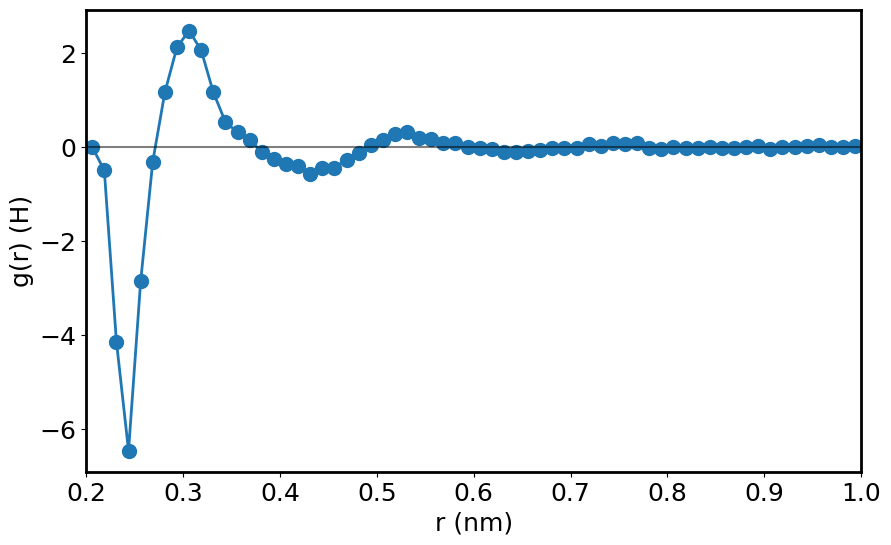

In [19]:
# charge density vs distance
# Compute charge density with respect to Na+ ion at box center.
# Select[ ] selects distance values in a given bin, and Total[ ] sums the charges.
# As for gOfr[ ] above, we normalize by dividing the total for each bin
# by the bin volume, times the average density of observed particles, 
# times the number of data points per particle (1001).
# The result is charge concentration in units of average molecue concentration.
# Charge density shows strong negative and positive peaks corresponding to strongly oriented dipoles in near-neighbor shell., followed by weak and diffuse second-neighbor peaks.  
def qOfr(data,xmin,xmax,nx):
    dx=(xmax-xmin)/nx
    return np.array([[xmin+(k-1/2)*dx, data[np.logical_and(data[:,0]>xmin+(k-1)*dx,data[:,0]<xmin+k*dx)][:,1].sum()/(4*np.pi*pow((xmin+(k-1/2)*dx),2)*dx*rho*1001)] for k in range(1,nx+1)])
qOfrData=qOfr(chargeData,0.2,1,64)
plt.figure(figsize=(10,6))
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.rcParams.update({"font.size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(qOfrData[:,0],qOfrData[:,1],marker="o",linewidth=2,markersize=10)
plt.hlines(0,xmin=0,xmax=1,color='black',alpha=0.5,zorder=5)
plt.ylabel("g(r) (H)",fontsize=18)
plt.xlabel("r (nm)",fontsize=18)

plt.xlim(0.2,1.0)
plt.savefig("qr(c).png",dpi=300)